In [1]:
import pandas as pd
import umap
import umap.plot
import matplotlib.pyplot as plt
import hdbscan
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn

from scipy.stats import kruskal
from scipy.stats import wilcoxon
from scipy.stats import f_oneway
from scikit_posthocs import posthoc_dunn
import skbio

from skbio import DistanceMatrix
from skbio.stats.distance import permanova

/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a 

In [2]:
np.random.seed(410)
reducer = umap.UMAP(random_state=42)
reducer_clustering = umap.UMAP(    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,)
hdbscan_alg = hdbscan.HDBSCAN(
        min_samples=10,
        min_cluster_size=500,
        gen_min_span_tree=False,
        approx_min_span_tree=False
    )

# If HDBSCAN use desired
def embed_umap(data):

    embedding = reducer.fit_transform(data)
    clusterable_embedding = reducer_clustering.fit_transform(data)
    cluster_labels = hdbscan_alg.fit_predict(clusterable_embedding)

    return embedding, cluster_labels, clusterable_embedding

def create_cancer_umap(embedding, labels, title, cancer_list):
    
    # Filter cancer patients
    cancer_patients = (labels > 0)
    
    # Plot non-cancer patients

    if len(embedding[~cancer_patients]) != 0:
        plt.scatter(embedding[~cancer_patients, 0],
                    embedding[~cancer_patients, 1],
                    color=(0.5, 0.5, 0.5),
                    s=8,
                    alpha=1,
                    label="No Cancer")
    
    # Get unique cancer labels
    unique_labels = np.unique(labels[cancer_patients])
    
    # Create color map
    cmap = plt.get_cmap('Spectral', len(unique_labels))
    
    # Plot cancer patients with correct color mapping
    for i, cancer_type in enumerate(unique_labels):
        mask = labels == cancer_type
        plt.scatter(embedding[mask, 0],
                    embedding[mask, 1],
                    color=cmap(i / (len(unique_labels) - 1)) if len(unique_labels) > 1 else cmap(0),
                    s=8,
                    label=cancer_list[int(cancer_type) - 1] if int(cancer_type) > 0 else "Unknown")
    
    # Create legend handles that match the scatter plot colors
    handles = [mpatches.Patch(color=cmap(i / (len(unique_labels) - 1)) if len(unique_labels) > 1 else cmap(0), 
                             label=cancer_list[int(label) - 1] if int(label) > 0 else "Unknown")
               for i, label in enumerate(unique_labels)]
    
    # Add non-cancer handle
    if len(embedding[~cancer_patients]) != 0:
        handles.append(mpatches.Patch(color=(0.5, 0.5, 0.5), label="No Cancer"))
    
    plt.title(title)
    plt.legend(handles=handles, title="Patient Labels", fontsize=5)
    
    

In [3]:
cancer_patients = pd.read_excel("../data/rise_cancer_data.xlsx")
all_patients = pd.read_csv("../data/rise_all_data.csv")

all_patients["cancer"] = all_patients["participantid"].isin(cancer_patients["participantid"])


In [ ]:
all_patients

In [4]:
# Previous filtering code

# cancer_patients
# dropped_columns_baseline = ["b1_age", "b1_e4_ft", "b1_e4_in", "b1_e4_cm", "b1_e5_lbs", "b1_e5_kg", "b1_e12d1", "b1_e14c1", "b1_e14c2", "b1_e14d1", "b1_e14e", "b1_e15a1", "b1_e15a2", "b1_e15a3", "b1_e15a4", "b1_e15a5", "b1_e15a6", "b1_e16a1a1", "b1_e16a"]
# dropped_columns_baseline_pregnancy = ["b1_e16b", "b1_e17", "b1_e17a_1", "b1_e17a_2", "b1_e17a1_lb", "b1_e17a1_oz", "b1_e17a1_gr", "b1_e17a2a", "b1_e17a2b", "b1_e17a2c", "b1_e17a2d", "b1_e17b_1", "b1_e17b_2", "b1_e17c", "b1_e17c1_m", "b1_e17c1_y", "b1_e17d", "b1_e17e", "b1_e17e1_m", "b1_e17e1_y"]
# dropped_columns_gender = ["b1_f2", "b1_f2o", "b1_f3", "b1_f3o", "b1_f4", "b1_f4o"]
# dropped_columns_race_and_socioeconomic = ["b1_f5", "b1_f6a", "b1_f6b", "b1_f6c", "b1_f6d", "b1_f6e", "b1_f6f", "b1_f6g", "b1_f6h", "b1_f6o", "b1_f7", "b1_f8", "b1_f9", "b1_f9o", "b1_f10", "b1_f10o1", "b1_f10o2", "b1_f11", "b1_f11o", "b1_f11a", "b1_f11ao", "b1_f12", "b1_f12a", "b1_f12b_y", "b1_f12b_m", "b1_f13", "b1_f13a", "b1_f13a_span", "b1_f13b_y", "b1_f13b_m", "b1_f14", "b1_f14a", "b1_f14a_span", "b1_f14b_m", "b1_f14b_y", "b1_f14c", "b1_f15", "b1_f16", "b1_f17", "b1_f18a", "b1_f18b", "b1_f18c", "b1_f18d", "b1_f18e", "b1_f18_a", "b1_f18o", "b1_f19", "b1_f19o", "b1_f20", "b1_f20a", "b1_f21", "b1_f22a", "b1_f22b", "b1_f22c", "b1_f22d", "b1_f23", "b1_f24", "b1_f25", "b1_f26", "b1_f27", "b1_f28", "baseline1_date"]
# dropped_columns_derived = ["age_4lvl", "age_4lvl_impute", "bmi.grp"]
# all_drop_columns = dropped_columns_baseline + dropped_columns_baseline_pregnancy + dropped_columns_gender + dropped_columns_race_and_socioeconomic + dropped_columns_derived
# all_drop_columns = list(set(all_drop_columns))
# all_drop_columns = [col for col in all_drop_columns if col in all_patients.columns]
# all_patients_filtered = all_patients.drop(columns=all_drop_columns)


# keep_na_cols = ["pregnant", "height", "weight", "bmi", "birth_control", "vaginal_parity", "deliveries_cesarean_6lvl", "deliveries_vaginal_6lvl", "gender", "fpl_pct"]
# keep_na_cols_bhs = ["bhs_1", "bhs_2", "bhs_3", "bhs_4", "bhs_5", "bhs_6", "bhs_7", "bhs_8", "bhs_9", "bhs_10", "bfi_biosis", "bfi_freq", "bfi_sensation", "bfi_continence", "bfi_comfort", "bfi_emptying"]
# cols_to_keep = keep_na_cols + keep_na_cols_bhs
# cols_to_keep = list(set(cols_to_keep))
# cols_to_keep = [col for col in cols_to_keep if col in all_patients_filtered.columns]
# all_patients_no_na = all_patients.dropna(axis=1)
# all_patients_no_na = pd.concat((all_patients_no_na, all_patients[cols_to_keep]), axis=1)
# all_drop_columns_no_na = [col for col in all_drop_columns if col in all_patients_no_na.columns]
# all_patients_no_na = all_patients_no_na.drop(columns=all_drop_columns_no_na)
# all_patients_no_na = all_patients_no_na.dropna(axis=0, subset=[])

# all_drop_columns_na = [col for col in all_patients_filtered.columns if col not in all_patients_dropna.columns]
# all_patients_dropna_filtered = all_patients_filtered.drop()

In [5]:
keep_cols_major_health = ["b1_e8a", "b1_e8b", "b1_e8c", "b1_e8d", "b1_e8e", "b1_e8f", "b1_e8g", "b1_e8h", "b1_e8i", "b1_e8j", "b1_e9a", "b1_e9c", "b1_e9d", "b1_e9e", "b1_e9f", "b1_e9g","b1_e11", "b1_e11a", "b1_e11a1", "b1_e11b", "b1_e11c", "b1_e11d", "b1_e11e", "b1_e11f", "b1_e11g", "b1_e12a", "b1_e12b", "b1_e12c", "b1_e12d", "b1_e12e", "b1_e12f", "b1_e12g", "b1_e12h", "b1_e12i", "b1_e19", "b1_e20"]
keep_cols_derived = ["menopause_impute"]
keep_cols_derived_necessary = ["age_impute", "height", "weight", "bmi"]
keep_cols_derived_imputable = ["pregnant"]
keep_cols_scales = [ "bhs_1_adj", "bhs_2_adj", "bhs_3_adj", "bhs_4_adj", "bhs_5_adj", "bhs_6_adj", "bhs_7_adj", "bhs_8_adj", "bhs_9_adj", "bhs_10_adj", "bfi_biosis", "bfi_freq", "bfi_sensation", "bfi_continence", "bfi_comfort", "bfi_emptying"]
keep_cols_basic = ["participantid", "cancer"]

keep_cols_all_imputable = keep_cols_derived_imputable + keep_cols_major_health
keep_cols_all_unimputable = keep_cols_basic + keep_cols_derived_necessary + keep_cols_scales + keep_cols_derived

all_patients_filtered = all_patients[ keep_cols_all_unimputable + keep_cols_all_imputable]
all_patients_filtered = all_patients_filtered.dropna(axis=0, subset=keep_cols_all_unimputable)
all_patients_filtered = all_patients_filtered.fillna(value=0)

all_patients_filtered_ohe = pd.get_dummies(all_patients_filtered, columns=keep_cols_derived)
all_patients_filtered_ohe[keep_cols_all_imputable] = all_patients_filtered_ohe[keep_cols_all_imputable].astype(bool)


cancer_column_labels = ["b1_e11", "b1_e11a", "b1_e11b","b1_e11c","b1_e11d","b1_e11e","b1_e11g"]
cancer_names = ["Unknown/Other Cancer", "Bladder", "Uterine", "Cervical", "Ovarian", "Colon", "Breast"]
cancer_column_label_dict = {col: i + 1 for i, col in enumerate(cancer_column_labels)}
cancer_column_label_dict["0"] = 0
cancer_column_dependents = ["b1_e11a1", "b1_e11f"]



# FOR VISUALIZATION ONLY, WE SET PATIENT UP137 (true for e11b, e11d, e11e (uterus, ovaries, and colon cancer) TO HAVE ONLY UTERINE CANCER ONLY (e11b)
all_patients_filtered_ohe.loc[all_patients_filtered_ohe["participantid"] == "UP137", "b1_e11d"] = False
all_patients_filtered_ohe.loc[all_patients_filtered_ohe["participantid"] == "UP137", "b1_e11e"] = False
# We also set "b1_e11" to  0 in rows where the patient has "b1_e11a", "b1_e11b","b1_e11c","b1_e11d","b1_e11e","b1_e11g" equal to 1
for row in all_patients_filtered_ohe.iterrows():
    if row[1]["b1_e11a"] or row[1]["b1_e11b"] or row[1]["b1_e11c"] or row[1]["b1_e11d"] or row[1]["b1_e11e"] or row[1]["b1_e11g"]:
        all_patients_filtered_ohe.loc[row[0], "b1_e11"] = False

specific_cancer_labels = pd.DataFrame(columns=["cancer"])
specific_cancer_labels["cancer"] = pd.from_dummies(all_patients_filtered_ohe[cancer_column_labels], default_category="0")
specific_cancer_labels = specific_cancer_labels["cancer"].apply((lambda x: cancer_column_label_dict[x])).values
all_patients_filtered_ohe = all_patients_filtered_ohe.drop(columns=cancer_column_labels)
all_patients_filtered_ohe = all_patients_filtered_ohe.drop(columns=cancer_column_dependents)


all_patients_filtered_categorical = all_patients_filtered_ohe.loc[:, all_patients_filtered_ohe.dtypes == bool]
all_patients_filtered_numerical = all_patients_filtered_ohe.loc[:, all_patients_filtered_ohe.dtypes != bool]
all_patients_filtered_numerical = all_patients_filtered_numerical.drop(columns="participantid")
all_patients_filtered_labels = all_patients_filtered_categorical["cancer"].values
all_patients_filtered_categorical = all_patients_filtered_categorical.drop(columns="cancer")


all_patients_labels_categorical = all_patients_filtered_ohe.loc[:, all_patients_filtered_ohe.dtypes == bool]

all_patients_filtered_ohe["cancer_labels"] = specific_cancer_labels
all_patients_filtered_ohe_cancer = all_patients_filtered_ohe[all_patients_filtered_ohe["cancer"] == True]

cancer_only_cancer_labels = all_patients_filtered_ohe_cancer["cancer_labels"].values
all_patients_filtered_ohe_cancer = all_patients_filtered_ohe_cancer.drop(columns="cancer_labels")

all_patients_filtered_categorical_cancer = all_patients_filtered_ohe_cancer.loc[:, all_patients_filtered_ohe_cancer.dtypes == bool]
all_patients_filtered_numerical_cancer = all_patients_filtered_ohe_cancer.loc[:, all_patients_filtered_ohe_cancer.dtypes != bool]
all_patients_filtered_numerical_cancer = all_patients_filtered_numerical_cancer.drop(columns="participantid")
all_patients_filtered_categorical_cancer = all_patients_filtered_categorical_cancer.drop(columns="cancer")




In [6]:
cancer_only_cancer_labels

array([7, 7, 1, 1, 7, 1, 1, 1, 1, 5, 1, 7, 1, 5, 4, 7, 7, 1, 3, 7, 1, 1,
       3, 7, 6, 6, 7, 1, 7, 7, 6, 1, 7, 1, 2, 6, 1, 7, 7, 1])

In [7]:
all_patients_labels_categorical

,cancer,pregnant,b1_e8a,b1_e8b,b1_e8c,b1_e8d,b1_e8e,b1_e8f,b1_e8g,b1_e8h,...,b1_e12f,b1_e12g,b1_e12h,b1_e12i,b1_e19,b1_e20,menopause_impute_1,menopause_impute_2,menopause_impute_3,menopause_impute_88
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,True,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
508,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
509,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
510,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [8]:
numerical_cancer_umap  = umap.UMAP(random_state=42).fit(sklearn.preprocessing.StandardScaler().fit_transform(all_patients_filtered_numerical_cancer.values))
numerical_umap  = umap.UMAP(random_state=42).fit(sklearn.preprocessing.StandardScaler().fit_transform(all_patients_filtered_numerical.values))

categorical_cancer_umap  = umap.UMAP(random_state=42).fit(all_patients_filtered_categorical_cancer.values, metric="jaccard")
categorical_umap  = umap.UMAP(random_state=42).fit(all_patients_filtered_categorical.values, metric="jaccard")

/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

In [9]:
umap_intersection = numerical_umap * categorical_umap
umap_intersection_cancer = numerical_cancer_umap * categorical_cancer_umap

umap_union = numerical_umap + categorical_umap
umap_union_cancer = numerical_cancer_umap + categorical_cancer_umap

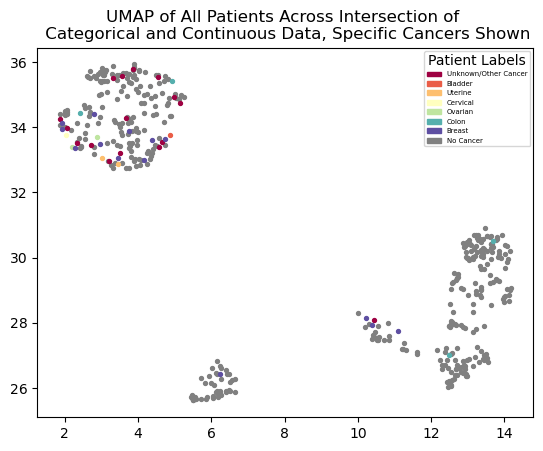

In [10]:
# umap.plot.points(umap_union., labels=all_patients_filtered_labels)
# plt.title("s")

create_cancer_umap(umap_intersection.embedding_, specific_cancer_labels, "UMAP of All Patients Across Intersection of \n Categorical and Continuous Data, Specific Cancers Shown", cancer_names)

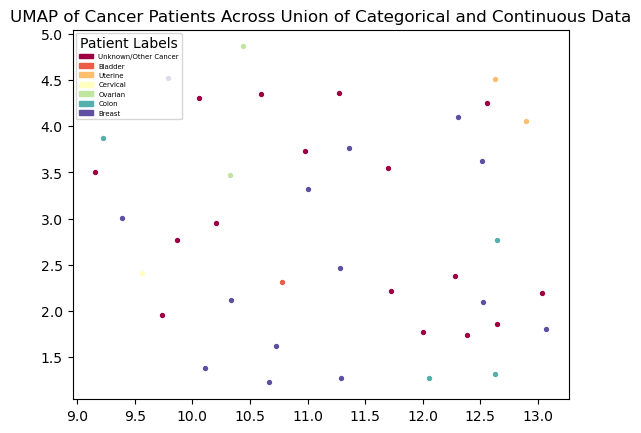

In [11]:
create_cancer_umap(umap_union_cancer.embedding_, cancer_only_cancer_labels, "UMAP of Cancer Patients Across Union of Categorical and Continuous Data", cancer_names)

Updated UMAP Plots

In [12]:
keep_categorical_updated = ["b1_e8a", "b1_e8b", "b1_e8c", "b1_e8d", "b1_e8e", "b1_e8f", "b1_e8g", "b1_e8h", "b1_e8i", "b1_e8j", "b1_e9a", "b1_e9c", "b1_e9d", "b1_e9e", "b1_e9f", "b1_e9g","b1_e19", "b1_e20", "pregnant","menopause_impute_1", "menopause_impute_2", "menopause_impute_3", "menopause_impute_88"]

keep_numerical_updated =["age_impute","bmi"]

updated_all_numerical = all_patients_filtered_numerical[keep_numerical_updated]
updated_all_categorical = all_patients_filtered_categorical[keep_categorical_updated]

In [13]:
updated_all_categorical_umap = umap.UMAP(random_state=42).fit(updated_all_categorical.values, metric="jaccard")
updated_all_numerical_umap = umap.UMAP(random_state=42).fit(sklearn.preprocessing.StandardScaler().fit_transform(updated_all_numerical.values))

/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
updated_all_umap_intersection = updated_all_numerical_umap * updated_all_categorical_umap
updated_all_umap_union = updated_all_numerical_umap + updated_all_categorical_umap

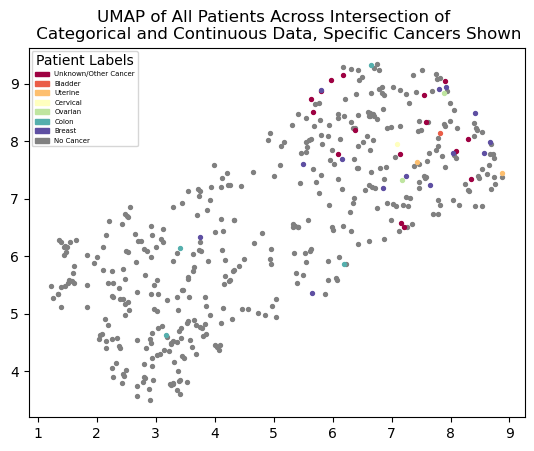

In [15]:
create_cancer_umap(updated_all_umap_intersection.embedding_, specific_cancer_labels, "UMAP of All Patients Across Intersection of \n Categorical and Continuous Data, Specific Cancers Shown", cancer_names)

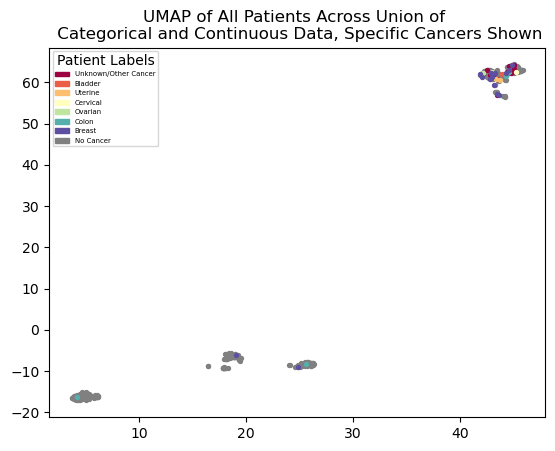

In [16]:
create_cancer_umap(updated_all_umap_union.embedding_, specific_cancer_labels, "UMAP of All Patients Across Union of \n Categorical and Continuous Data, Specific Cancers Shown", cancer_names)

In [17]:
all_patients_distances = pd.DataFrame(columns=["participantid", "Cancer Type"])
all_patients_distances["participantid"] = all_patients_filtered_ohe["participantid"]
all_patients_distances["UMAP Coordinate"] = [row for row in updated_all_umap_intersection.embedding_]
all_patients_distances["Cancer Type"] = specific_cancer_labels

non_cancer_distances = all_patients_distances[all_patients_distances["Cancer Type"] == 0]
cancer_distances = all_patients_distances[all_patients_distances["Cancer Type"] != 0]

# Get nearest non-cancer patient for each cancer patient
nearest_non_cancer = []
for cancer_patient in cancer_distances.iterrows():
    distances = np.linalg.norm(cancer_patient[1]["UMAP Coordinate"] - np.stack(non_cancer_distances["UMAP Coordinate"].values), axis=1)
    while True:
        if non_cancer_distances.iloc[np.argmin(distances)]["participantid"] not in nearest_non_cancer:
            nearest_non_cancer.append(non_cancer_distances.iloc[np.argmin(distances)]["participantid"])
            break
        else:
            distances[np.argmin(distances)] = np.inf    


In [18]:
cancer_distances["Nearest Non-Cancer Patient"] = nearest_non_cancer

/tmp/ipykernel_12406/635438334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_distances["Nearest Non-Cancer Patient"] = nearest_non_cancer


In [19]:
cancer_distances.to_csv("../output_data/rise_cancer_patients_nearest_neighbors.csv", index=False)

Generate Violin Plots to Visualize Bladder Health Scales

In [20]:
cancer_distances["participantid"].values

array(['EM120', 'LU012', 'LU018', 'LU048', 'NU018', 'NU024', 'NU080',
       'NU143', 'NU166', 'NU189', 'NU213', 'NU233', 'UA083', 'UC018',
       'UC137', 'UC146', 'UM012', 'UM081', 'UM199', 'UP002', 'UP107',
       'UP116', 'UP137', 'UP174', 'UP179', 'UP192', 'WU004', 'WU023',
       'WU081', 'WU087', 'WU088', 'WU116', 'WU126', 'WU227', 'WU252',
       'YU015', 'YU026', 'YU081', 'YU161', 'YU238'], dtype=object)

In [21]:
len(np.unique(cancer_distances["Nearest Non-Cancer Patient"].values))

40

In [44]:
all_patients[all_patients["participantid"].isin(cancer_distances["participantid"].values)]

,participantid,b1_age,b1_e1,b1_e2,b1_e3,b1_e4_ft,b1_e4_in,b1_e4_cm,b1_e5_lbs,b1_e5_kg,...,bhs_6_adj,bhs_7_adj,bhs_8_adj,bhs_9_adj,bhs_10_adj,bfi_overall,bh_urobiome_barcode,pass_kseq_threshold,sample_type,cancer
25,EM120,88.0,1.0,2.0,5,5,4,NaN,119,NaN,...,71.428571,67.610063,69.028340,68.779343,66.260163,89.473684,NaN,NaN,NaN,True
33,LU012,62.0,2.0,2.0,5,5,6,NaN,200,NaN,...,100.000000,100.000000,85.425101,100.000000,100.000000,100.000000,X00232826,y,pilot2,True
35,LU018,66.0,2.0,2.0,5,5,6,NaN,188,NaN,...,18.571429,13.836478,10.121457,19.718310,9.756098,72.807018,X00233772,y,research,True
48,LU048,60.0,0.0,2.0,5,5,8,NaN,244,NaN,...,77.142857,68.553459,74.493927,77.464789,77.235772,94.736842,X00232524,y,pilot2,True
97,NU018,74.0,2.0,2.0,4,5,7,NaN,198,NaN,...,48.571429,40.566038,27.125506,30.281690,26.829268,50.000000,X00233904,y,pilot2,True
98,NU024,69.0,1.0,1.0,5,5,6,NaN,160,NaN,...,57.142857,77.358491,43.319838,61.032864,37.398374,28.383459,X00232179,n,pilot1,True
111,NU080,84.0,1.0,1.0,5,5,0,NaN,175,NaN,...,31.428571,15.094340,19.838057,15.492958,24.390244,85.964912,NaN,NaN,NaN,True
130,NU143,60.0,1.0,1.0,5,5,3,NaN,115,NaN,...,48.571429,39.622642,51.417004,57.746479,36.585366,50.877193,NaN,NaN,NaN,True
136,NU166,69.0,1.0,2.0,5,5,7,NaN,132,NaN,...,100.000000,100.000000,100.000000,87.323944,92.682927,58.771930,NaN,NaN,NaN,True
141,NU189,82.0,1.0,2.0,5,5,1,NaN,114,NaN,...,31.428571,30.188679,30.769231,32.394366,29.268293,73.684211,NaN,NaN,NaN,True


In [22]:
bladder_health_scales = all_patients_filtered_numerical.drop(columns=["age_impute", "height", "weight", "bmi"])
bladder_health_scales["participantid"] = all_patients_filtered_ohe["participantid"]

all_cancer_bladder_health_scales = bladder_health_scales[bladder_health_scales["participantid"].isin(cancer_distances["participantid"].values)]
all_non_cancer_bladder_health_scales = bladder_health_scales[bladder_health_scales["participantid"].isin(cancer_distances["Nearest Non-Cancer Patient"].values)]

all_cancer_bladder_health_scales = all_cancer_bladder_health_scales.drop(columns="participantid")
all_non_cancer_bladder_health_scales = all_non_cancer_bladder_health_scales.drop(columns="participantid")


In [23]:
# Create combined dataframe for violin plots


def alternate_columns(df1, df2, suffix1="_cancer", suffix2="_control"):
    """
    Combines two DataFrames by alternating their columns and appends suffixes to column names.
    
    Parameters:
    df1 (pandas.DataFrame): First DataFrame
    df2 (pandas.DataFrame): Second DataFrame
    suffix1 (str): Suffix to append to column names from df1
    suffix2 (str): Suffix to append to column names from df2
    
    Returns:
    pandas.DataFrame: A new DataFrame with alternating columns from df1 and df2
    
    Note: If one DataFrame has more columns than the other, the remaining columns 
    will be appended at the end.
    """
    result = pd.DataFrame()
    
    # Get column names from both dataframes
    cols1 = df1.columns.tolist()
    cols2 = df2.columns.tolist()
    
    # Find the maximum length to iterate through
    max_cols = max(len(cols1), len(cols2))
    
    # Alternate columns from each dataframe
    for i in range(max_cols):
        # Add column from df1 if available with renamed column
        if i < len(cols1):
            new_col_name = cols1[i] + suffix1
            result[new_col_name] = df1[cols1[i]]
        
        # Add column from df2 if available with renamed column
        if i < len(cols2):
            new_col_name = cols2[i] + suffix2
            result[new_col_name] = df2[cols2[i]]
    
    return result



violin_plot_df = alternate_columns(all_cancer_bladder_health_scales.reset_index().drop(columns="index"), all_non_cancer_bladder_health_scales.reset_index().drop(columns="index"))

# Generate violin plots for each bladder health scale, comparing cancer patients to their nearest non-cancer patients

# ax, fig = plt.subplots(
# for scale in all_cancer_bladder_health_scales.columns:

# all_non_cancer_bladder_health_scales

Text(0.5, 1.0, 'Bladder Health Scales for Cancer Patients and Control Patients')

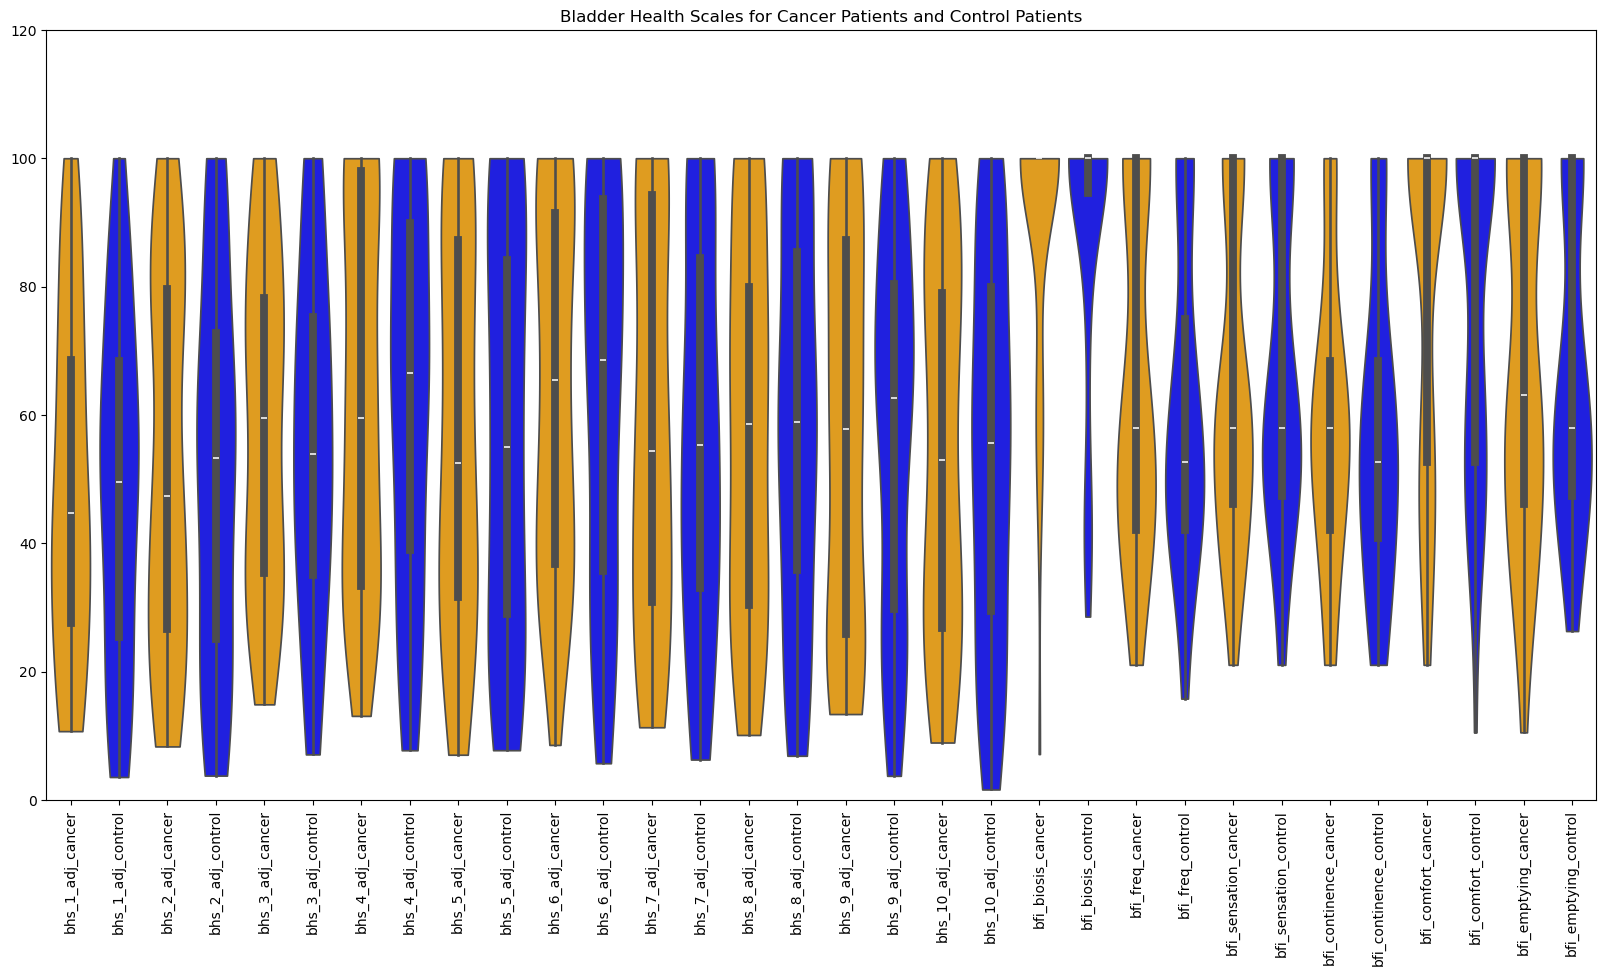

In [24]:
custom_palette = ['orange', 'blue'] * 16

plt.figure(figsize=(20, 10))
plt.ylim(0, 120)

sns.violinplot(data=violin_plot_df, palette=custom_palette, cut=0)
plt.xticks(rotation=90)
plt.title("Bladder Health Scales for Cancer Patients and Control Patients")

In [25]:
kruskal(*violin_plot_df.values.T)

KruskalResult(statistic=np.float64(145.03988035775637), pvalue=np.float64(1.126875372517504e-16))

In [26]:
# Iterate through each scale (i, i+2, i+4, ...) and perform Wilcoxon signed-rank test between i and i+1, i+2 and i+3, etc.


for i in range(0, len(violin_plot_df.columns), 2):
    print(wilcoxon(violin_plot_df.values.T[i], violin_plot_df.values.T[i+1]))



WilcoxonResult(statistic=np.float64(406.5), pvalue=np.float64(0.9624773051671748))
WilcoxonResult(statistic=np.float64(339.0), pvalue=np.float64(0.6477992188034503))
WilcoxonResult(statistic=np.float64(359.0), pvalue=np.float64(0.6653018032860004))
WilcoxonResult(statistic=np.float64(335.0), pvalue=np.float64(0.8034170519443014))
WilcoxonResult(statistic=np.float64(364.0), pvalue=np.float64(0.9248870033632757))
WilcoxonResult(statistic=np.float64(322.0), pvalue=np.float64(0.8627832300307605))
WilcoxonResult(statistic=np.float64(342.0), pvalue=np.float64(0.6793600253012481))
WilcoxonResult(statistic=np.float64(367.5), pvalue=np.float64(0.9652961548150304))
WilcoxonResult(statistic=np.float64(365.5), pvalue=np.float64(0.9421911577841113))
WilcoxonResult(statistic=np.float64(368.0), pvalue=np.float64(0.7588301068632963))
WilcoxonResult(statistic=np.float64(54.0), pvalue=np.float64(0.467920807331738))
WilcoxonResult(statistic=np.float64(217.5), pvalue=np.float64(0.38417819289803035))
Wilco

In [27]:
wilcoxon(violin_plot_df.values.T[30], violin_plot_df.values.T[31])

WilcoxonResult(statistic=np.float64(257.0), pvalue=np.float64(0.6743607232376541))

In [28]:
violin_plot_df

,bhs_1_adj_cancer,bhs_1_adj_control,bhs_2_adj_cancer,bhs_2_adj_control,bhs_3_adj_cancer,bhs_3_adj_control,bhs_4_adj_cancer,bhs_4_adj_control,bhs_5_adj_cancer,bhs_5_adj_control,...,bfi_freq_cancer,bfi_freq_control,bfi_sensation_cancer,bfi_sensation_control,bfi_continence_cancer,bfi_continence_control,bfi_comfort_cancer,bfi_comfort_control,bfi_emptying_cancer,bfi_emptying_control
0,63.988095,75.892857,56.818182,100.000000,71.631206,74.468085,67.857143,89.285714,71.830986,100.000000,...,100.000000,36.842105,68.421053,100.000000,68.421053,100.000000,100.000000,36.842105,100.000000,36.842105
1,86.607143,100.000000,86.363636,100.000000,80.851064,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2,12.351190,78.571429,10.984848,86.363636,22.695035,93.617021,22.767857,97.321429,18.544601,95.774648,...,52.631579,100.000000,42.105263,63.157895,42.105263,63.157895,100.000000,63.157895,100.000000,63.157895
3,64.880952,42.808219,77.272727,43.181818,77.304965,54.609929,77.358491,54.761905,67.605634,52.582160,...,100.000000,68.421053,100.000000,57.894737,68.421053,57.894737,100.000000,100.000000,100.000000,100.000000
4,23.660714,52.380952,18.181818,56.818182,36.170213,53.191489,32.075472,71.726190,26.056338,23.004695,...,42.105263,57.894737,36.842105,100.000000,36.842105,47.368421,47.368421,100.000000,36.842105,31.578947
5,56.547619,56.250000,50.757576,54.545455,72.340426,82.978723,77.380952,71.875000,47.887324,83.098592,...,36.842105,63.157895,36.842105,47.368421,26.315789,52.631579,31.578947,100.000000,31.578947,57.894737
6,12.500000,89.285714,20.454545,86.363636,31.914894,74.468085,25.892857,100.000000,29.577465,100.000000,...,100.000000,73.684211,57.894737,63.157895,57.894737,68.421053,100.000000,68.421053,100.000000,73.684211
7,41.071429,67.857143,43.181818,72.727273,57.446809,80.851064,57.142857,100.000000,46.478873,100.000000,...,42.105263,47.368421,36.842105,100.000000,52.631579,68.421053,31.578947,100.000000,42.105263,100.000000
8,70.850202,35.714286,86.363636,61.363636,87.234043,57.446809,100.000000,71.130952,100.000000,54.460094,...,42.105263,42.105263,52.631579,57.894737,52.631579,42.105263,52.631579,42.105263,52.631579,100.000000
9,27.678571,11.309524,25.773196,11.363636,31.914894,17.730496,32.155477,17.261905,32.394366,21.126761,...,63.157895,100.000000,57.894737,47.368421,57.894737,52.631579,100.000000,52.631579,63.157895,52.631579


In [29]:
all_cancer_bladder_health_scales_labeled = all_cancer_bladder_health_scales
all_cancer_bladder_health_scales["cancer"] = 1
all_non_cancer_bladder_health_scales_labeled = all_non_cancer_bladder_health_scales
all_non_cancer_bladder_health_scales["cancer"] = 0

Segregate by Cancer Type

In [31]:
cancer_names = ["Unknown/Other Cancer", "Bladder", "Uterine", "Cervical", "Ovarian", "Colon", "Breast"]
no_cancer = [0]
non_gyn_cancer = [1, 6]
gyn_breast_cancers = [3, 4, 5, 7]

bladder_health_scales["cancer_subtype"] = specific_cancer_labels
bladder_health_scales_filtered = bladder_health_scales[bladder_health_scales["cancer_subtype"] != 2]
bladder_health_scales_filtered["cancer_group"] = bladder_health_scales_filtered["cancer_subtype"].apply(lambda x: 0 if x in no_cancer else 1 if x in non_gyn_cancer else 2 if x in gyn_breast_cancers else 2193012309213120321321)

/tmp/ipykernel_12406/1423797008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bladder_health_scales_filtered["cancer_group"] = bladder_health_scales_filtered["cancer_subtype"].apply(lambda x: 0 if x in no_cancer else 1 if x in non_gyn_cancer else 2 if x in gyn_breast_cancers else 2193012309213120321321)


In [32]:
bladder_health_scales_filtered
bhs_controls_filtered = bladder_health_scales_filtered[bladder_health_scales_filtered["participantid"].isin([item for item in cancer_distances["Nearest Non-Cancer Patient"].values.tolist() if item != "UC200"])]
bhs_cancer_filtered = bladder_health_scales_filtered[bladder_health_scales_filtered["cancer_group"] != 0]

bhs_cancer_controls = pd.concat([bhs_cancer_filtered, bhs_controls_filtered], axis=0)
bhs_cancer_controls.drop(columns=["participantid", "cancer_subtype"], inplace=True)

In [33]:

from skbio.diversity import beta_diversity

for column in bhs_cancer_controls.columns:
    distance_matrix = beta_diversity("euclidean", bhs_cancer_controls[column].values.reshape(-1,1), ids=bhs_cancer_controls.index)

    # Convert to a DistanceMatrix object
    dm = DistanceMatrix(distance_matrix, ids=bhs_cancer_controls.index)

    # Grouping variable
    grouping = bhs_cancer_controls['cancer_group']

    # Perform PERMANOVA
    result = permanova(distance_matrix=dm, grouping=grouping, permutations=999)
    print(f"{column}: {result["p-value"]}")


bhs_1_adj: 0.466
bhs_2_adj: 0.352
bhs_3_adj: 0.454
bhs_4_adj: 0.617
bhs_5_adj: 0.756
bhs_6_adj: 0.596
bhs_7_adj: 0.738
bhs_8_adj: 0.715
bhs_9_adj: 0.663
bhs_10_adj: 0.674
bfi_biosis: 0.521
bfi_freq: 0.541
bfi_sensation: 0.612
bfi_continence: 0.676
bfi_comfort: 0.897
bfi_emptying: 0.89


/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/skbio/stats/distance/_permanova.py:136: RuntimeWarning: divide by zero encountered in scalar divide
  return (s_A / (num_groups - 1)) / (s_W / (sample_size - num_groups))


cancer_group: 0.001


In [34]:
bhs_cancer_filtered.groupby("cancer_group")

In [35]:
# for i in range(bhs_cancer_controls.groupby("cancer_group").get_group(0).shape[1]):
#     for j in bhs_cancer_controls.groupby("cancer_group"):
#         print(j[1].loc[:, j[1].columns[i]].values)

In [41]:
# Iterate through each column, group by cancer group, and perform kruskal test
for i, column in enumerate(bhs_cancer_controls.columns):
    if column == "cancer_group":
        continue
    print(f"{column}: {f_oneway(*[j[1].loc[:, j[1].columns[i]].values for j in bhs_cancer_controls.groupby("cancer_group")]).pvalue}")

    # Also get mean median and std for each group
    # print(f"Mean: {np.round(bhs_cancer_controls.groupby("cancer_group").mean().loc[:, column].values, 3).tolist()}")
    # print(f"Median: {np.round(bhs_cancer_controls.groupby("cancer_group").median().loc[:, column].values, 3).tolist()}")
    # print(f"STD: {np.round(bhs_cancer_controls.groupby("cancer_group").std().loc[:, column].values, 3).tolist()}")


bhs_1_adj: 0.4645250407974705
bhs_2_adj: 0.33784439659328974
bhs_3_adj: 0.44930605174247307
bhs_4_adj: 0.6214978380184875
bhs_5_adj: 0.7600860873001193
bhs_6_adj: 0.6009863449110843
bhs_7_adj: 0.7245468978735847
bhs_8_adj: 0.7153112391360199
bhs_9_adj: 0.6623279524104196
bhs_10_adj: 0.6694221855111424
bfi_biosis: 0.5023531145979767
bfi_freq: 0.5682153538515549
bfi_sensation: 0.6055731508632289
bfi_continence: 0.6876571565426153
bfi_comfort: 0.8938398388070551
bfi_emptying: 0.8808591286060821


In [37]:
[j[1].loc[:, j[1].columns[i]].values for j in bhs_cancer_controls.groupby("cancer_group")]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])]

In [38]:
for j in bhs_cancer_controls.groupby("cancer_group"):
    print(len(j[1].loc[:, j[1].columns[0]].values))

40
20
19
